In [1]:
import os
import tempfile
import numpy as np
import pandas as pd
import qiime2 as q2
from tqdm.notebook import tqdm
from biom import Table, load_table

from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.distance import permanova
from qiime2.plugins.diversity.actions import beta_group_significance


from qiime2.plugins.diversity.methods import beta_phylogenetic
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins.feature_table.methods import rarefy


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline


In [597]:
# import and merge
mf1 = pd.read_csv('../data/long_IH_IC_micro_metadata.txt', sep='\t', index_col=0)
mf2 = pd.read_csv('../data/longIHC_micro_metadata_cleaned.txt', sep='\t', index_col=0)
mf1['study'] = 'IH_IC'
mf2['study'] = 'IHC'
mf = pd.concat([mf1,mf2], axis=0)
mf['mouse_number'] = [v.replace(' ','_') if isinstance(v, str) else 'Mouse_' + str(v)
                      for v in mf['mouse_number']]
mf = mf.drop(['dna_extracted','physical_specimen_remaining'], axis=1)
mf = mf[mf.diet == 'HFD']
mf = mf[mf.sample_type != 'tooth']
print(mf.shape)
# import table
btdf1 = pd.read_csv('../data/longIHC_HFD_fecal_counts.tsv', sep='\t', index_col=0, low_memory=False)
btdf2 = pd.read_csv('../data/longIHIC_HFD_fecal_counts.txt', sep='\t', index_col=0, low_memory=False)
btdf = pd.concat([btdf1, btdf2], axis=1).fillna(0)
btdf = btdf.groupby(btdf.index).sum()
print(btdf.shape)
# match
shared_ = set(mf.index) & set(btdf.columns)
mf = mf.reindex(shared_)
btdf = btdf.reindex(shared_, axis=1)
btdf = btdf.loc[btdf.sum(1) > 0, :]
bt = Table(btdf.values, btdf.index, btdf.columns)
print(mf.shape)
print(btdf.shape)

# add a total sum filter of ten (need to limit features for st2)
n_features, n_samples = bt.shape
min_sample_count = 1500
min_feature_count = 0
min_feature_frequency = 0.0

# filter sample to min seq. depth
def sample_filter(val, id_, md):
    return sum(val) > min_sample_count

# filter features to min total counts
def observation_filter(val, id_, md):
    return sum(val) > min_feature_count

# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)

# filter and import table for each filter above
bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(sample_filter, axis='sample')
mf = mf.reindex(bt.ids())
print(bt.shape)

# import 
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
metadata = q2.Metadata(mf)

# import taxa
tx1 = q2.Artifact.load('../data/IHIC_taxonomy.qza').view(pd.DataFrame)
tx2 = q2.Artifact.load('../data/longIHC_taxonomy_59133.qza').view(pd.DataFrame)
taxa = pd.concat([tx1, tx2], axis=0)
taxa = taxa[~taxa.index.duplicated(keep='first')]
taxa = taxa.reindex(bt.ids('observation'))



(1600, 53)
(17393, 1320)
(1297, 53)
(12696, 1297)
(12696, 1276)


In [518]:
from gemelli.ctf import ctf_helper

import biom
import skbio
from pandas import concat
from pandas import DataFrame
from skbio import OrdinationResults, DistanceMatrix
from gemelli.factorization import TensorFactorization
from gemelli.preprocessing import build, rclr
from gemelli._ctf_defaults import (DEFAULT_COMP, DEFAULT_MSC,
                                   DEFAULT_MFC, DEFAULT_MAXITER,
                                   DEFAULT_FMETA as DEFFM)


In [542]:
popctf = ctf_helper(bt, mf, 'mouse_number',
                       ['host_age'],
                        feature_metadata=taxa,
                        n_components=3,
                        max_iterations_als=5,
                        max_iterations_rptm=5,
                        n_initializations=5)
TFfit = ctf_helper(bt, mf, 'study',
                   ['mouse_number',
                    'host_age'],
                    feature_metadata=taxa,
                    n_components=3,
                    max_iterations_als=5,
                    max_iterations_rptm=5,
                    n_initializations=5)
                
(state_ordn, subj_ordin, distances,
 subject_trajectories, feature_trajectories) = TFfit



/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/gemelli/preprocessing.py:356: RuntimeWarning: Subject(s) () contains multiple samples. Multiple subject counts will be meaned across samples by subject.
  RuntimeWarning)


In [583]:
exposure_type_dict = metadata.to_dataframe().groupby('mouse_number').agg({'exposure_type':'first'}).to_dict()['exposure_type']
study_dict = metadata.to_dataframe().groupby('mouse_number').agg({'study':'first'}).to_dict()['study']
cage_dict = metadata.to_dataframe().groupby('mouse_number').agg({'cage_number':'first'}).to_dict()['cage_number']
subject_loadings = state_ordn['mouse_number'].samples.copy()
subject_loadings[['PC1','PC2']] -= subject_loadings[['PC1','PC2']].mean(axis=0)
subject_loadings['exposure_type'] = [exposure_type_dict[v] for v in subject_loadings.index]
subject_loadings['study'] = [study_dict[v] for v in subject_loadings.index]
subject_loadings['cage'] = [cage_dict[v] for v in subject_loadings.index]
subject_loadings.index.name = 'sample_name'


In [588]:
from scipy.spatial import distance

subject_loadings.loc[subject_loadings.exposure_type != 'Air', 'study'] = 'IH_IC'
dist_all = distance.cdist(subject_loadings[['PC1','PC2']],
                       subject_loadings[['PC1','PC2']])
dist_all = DistanceMatrix(dist_all, subject_loadings.index)

subject_loadings_ = subject_loadings[subject_loadings.exposure_type == 'Air']
dist_air = distance.cdist(subject_loadings_[['PC1','PC2']],
                           subject_loadings_[['PC1','PC2']])
dist_air = DistanceMatrix(dist_air, subject_loadings_.index)



In [596]:
# run pairwise permanova
perm_res = beta_group_significance(q2.Artifact.import_data('DistanceMatrix', dist_all),
                                   q2.Metadata(subject_loadings).get_column('exposure_type'),
                                   pairwise=True, permutations=50000)
# save all intermediate files into tmp dir
with tempfile.TemporaryDirectory() as temp_dir_name:
    perm_res.visualization.export_data(temp_dir_name)
    pairwisedf = pd.read_csv(os.path.join(temp_dir_name,
                                          'permanova-pairwise.csv'))
pairwisedf = pairwisedf.set_index(['Group 1','Group 2'])
pairwisedf.index.names = ['Group 1','Group 2']
pairwisedf


Sample size  Permutations   pseudo-F   p-value   q-value
Group 1 Group 2                                                          
Air     IC                36         50000  19.859989  0.000100  0.000120
        IH                36         50000  87.592060  0.000020  0.000030
        IHC               32         50000  23.684124  0.000020  0.000030
IC      IH                32         50000  17.942479  0.000020  0.000030
        IHC               28         50000   0.061864  0.940901  0.940901
IH      IHC               28         50000  18.943233  0.000020  0.000030

<Figure size 432x288 with 0 Axes>

In [595]:
permanova(dist_all, subject_loadings['exposure_type'], permutations=50000)


method name                 PERMANOVA
test statistic name          pseudo-F
sample size                        64
number of groups                    4
test statistic                29.9628
p-value                   1.99996e-05
number of permutations          50000
Name: PERMANOVA results, dtype: object

In [600]:
permanova(dist_air, subject_loadings_['study'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  2
test statistic              3.64561
p-value                       0.057
number of permutations          999
Name: PERMANOVA results, dtype: object

In [571]:
# split taxonomy for both
def add_taxsplit(taxdf):

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxdf.columns:
            taxonomy_tmp = []
            for tax in taxdf.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxdf[lname] = taxonomy_tmp
    return taxdf


feature_loadings = feature_trajectories['mouse_number'].copy()
feature_loadings = feature_loadings.groupby('feature_id').mean()
feature_loadings = pd.concat([feature_loadings, taxa], axis=1)
feature_loadings = add_taxsplit(feature_loadings)
feature_loadings[['PC1','PC2']] -= feature_loadings[['PC1','PC2']].mean(axis=0)
feature_loadings['norms'] = np.linalg.norm(feature_loadings[['PC1','PC2']], axis=-1)
#feature_loadings['PC1'] = feature_loadings['PC1'] * 10
#feature_loadings['PC2'] = feature_loadings['PC2'] / 10
#np.linalg.norm(feature_loadings[['PC1','PC2']], axis=-1)


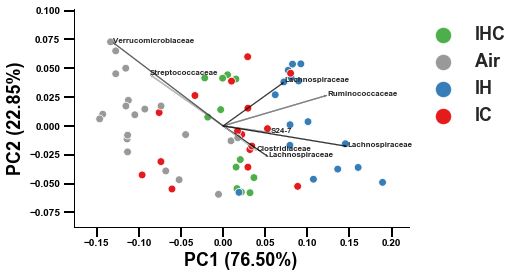

In [615]:

n_ = 7
level_ = 'family'

pal_ = {'IH': '#377eb8', 'IHC': '#4daf4a',
        'Air': '#999999', 'IC': '#e41a1c'}
               
from matplotlib.pyplot import cm
from adjustText import adjust_text
    
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.scatterplot(x='PC1', y='PC2',
                hue='exposure_type',
                #style='study',
                ax=ax,
                s=60,
                palette=pal_,
                data=subject_loadings)

prop_ = popctf[0]['host_age'].proportion_explained[0] * 100
ax.set_xlabel('%s (%.2f%%)' % ('PC1', prop_),
              fontsize=18,
              color='black')
prop_ = popctf[0]['host_age'].proportion_explained[1] * 100
ax.set_ylabel('%s (%.2f%%)' % ('PC2', prop_),
              fontsize=18,
              color='black')

# add arrows
ftraj_ = feature_loadings.dropna(subset=[level_])

subset_arrows = [df_.sort_values(v_, ascending=a_).iloc[0,:]
                 for k_, df_ in ftraj_.groupby(level_)
                 for v_ in ['PC1','PC2'] for a_ in [True, False]]
ftraj_ = pd.concat(subset_arrows, axis=1).T
ftraj_plot = pd.concat([ftraj_.sort_values('PC2').iloc[-n_//2:, :],
                        ftraj_.sort_values('PC2').iloc[:n_//2, :],
                        ftraj_.sort_values('PC1').iloc[-n_//2:, :],
                        ftraj_.sort_values('PC1').iloc[:n_//2, :]])
ftraj_plot = ftraj_plot[~ftraj_plot.index.duplicated(keep='first')]
taxset = set(ftraj_plot[level_])
color = cm.Greys(np.linspace(0,1,len(taxset)))
acmap = {i:c for i,c in zip(taxset,color)}
annots = []
seqs = []
texts = []
limits_x = []
limits_y = []
scale_ = 2.5

for i in ftraj_plot.index:
    annots.append(ax.arrow(0, 0,
                           ftraj_plot.loc[i, 'PC1'] * scale_,
                           ftraj_plot.loc[i, 'PC2'] * scale_,
                           color=acmap[ftraj_plot.loc[i, level_]],
                           alpha=0.8,
                           lw=0.25,
                           ec = "black",
                           length_includes_head=True,
                           head_width=.002, width=.0009, zorder=100))
    limits_x.append(ftraj_plot.loc[i, 'PC1'] * 1)
    limits_y.append(ftraj_plot.loc[i, 'PC2'] * 1)
    texts.append(ax.text(ftraj_plot.loc[i, 'PC1'] * scale_ ,
                 ftraj_plot.loc[i, 'PC2'] * scale_ ,
                 ftraj_plot.loc[i, level_], zorder=100,
                 fontsize=8))
    seqs.append(i)  
#adjust_text(texts)

    
ax.grid(False)
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:7] + handles[8:],
                   labels[1:7] +labels[8:],
                   loc=2, 
                   bbox_to_anchor=(1, 1),
                   prop={'size':18},
                   fancybox=False, framealpha=.0,
                   ncol=1, markerscale=2.5)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
ax.tick_params(axis='y', colors='black', width=2, length=10, reset=True,
               left=True, right=False)
ax.tick_params(axis='x', colors='black', width=2, length=10, reset=True,
               bottom=True, top=False, pad=2)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

#ax.spines['left'].set_bounds(-0.2,0.2)
#ax.set_ylim(-.25,.25)

#ax.spines['bottom'].set_bounds(-0.06,0.06)
#ax.set_xlim(-0.065,0.065)

for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(10)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(10)
ax.tick_params(axis='y', colors='black', width=2, length=10, reset=True,
               left=True, right=False)
ax.tick_params(axis='x', colors='black', width=2, length=10, reset=True,
               bottom=True, top=False, pad=2)

# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
plt.savefig('../results/CTF-ord-plot.pdf',
           dpi=250, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()


In [599]:
set(ftraj_plot[level_])

{'Clostridiaceae',
 'Lachnospiraceae',
 'Ruminococcaceae',
 'S24-7',
 'Streptococcaceae',
 'Verrucomicrobiaceae'}

In [614]:
ord_res_save = OrdinationResults('CTF subject biplot',
                                'CTF subject biplot',
                                popctf[0]['host_age'].eigvals.copy(),
                                samples=subject_loadings[['PC1','PC2']].copy(),
                                features=feature_loadings[['PC1','PC2']].copy(),
                                proportion_explained=popctf[0]['host_age'].proportion_explained.copy())
subjectmf = subject_loadings[['exposure_type']]
ord_res_save = q2.Artifact.import_data('PCoAResults % Properties("biplot")', ord_res_save)
ord_res_save.save('../results/subject-biplot.qza')
subjectmf.to_csv('../results/subject-metadata.tsv', sep='\t')
